**Imports & Installations**

In [ ]:
import sys
import subprocess
import random
import numpy as np
import pandas as pd
from collections import defaultdict

# --- VISUALIZATION LIBRARIES ---
import matplotlib.pyplot as plt
import seaborn as sns

# Install libraries if missing
def install(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

print("Checking dependencies...")
install("optuna")
install("pytorch_tabnet")
install("xgboost")
install("lightgbm")
install("imblearn")
install("matplotlib")
install("seaborn")

# Core ML
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, roc_auc_score, roc_curve, auc, confusion_matrix
)

# Imbalanced Learning
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE

# Deep Learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier

# Tree Models
import xgboost as xgb
import lightgbm as lgb

# Optimization
import optuna

Checking dependencies...


**Config**

In [ ]:
SEED = 42
def set_seeds(seed=SEED):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds()

Encoder = "Label Encoder"
OverSamplingTecnique = "SMOTE"
MODEL_TYPE = "FT-Transformer"
TRIALS = 30

**Load and Proccess Data**

In [ ]:
url = "https://raw.githubusercontent.com/mahidul5130/ChurnNet_Deep_Learning_Enhanced_Customer_Churn-Prediction_in_Telecommunication_Industry/refs/heads/main/Churn-data-UCI%20Dataset(5000).csv"
df_raw = pd.read_csv(url)

print(f"Dataset shape: {df_raw.shape}")

# 1. Define Features and Target
target_col = 'churn'
df_raw[target_col] = df_raw[target_col].astype(int)
X_raw = df_raw.drop(columns=[target_col])
# Ensure target is integer
Y = df_raw[target_col].values.astype(int)

# ---------------------------

# 2. Explicitly define categorical columns
cat_cols = ['internationalplan', 'voicemailplan']
available_cat_cols = [c for c in cat_cols if c in X_raw.columns]
print(f"Categorical Columns to Encode: {available_cat_cols}")

# 3. Apply Encoding
df_final = X_raw.copy()

if Encoder == "Label Encoder":
    le = LabelEncoder()
    for col in available_cat_cols:
        df_final[col] = le.fit_transform(df_final[col].astype(str))
        print(f"Encoded {col}: {df_final[col].unique()}")
    X = df_final.values
else:
    X = df_final.values

# 4. Helper for Oversampling
def get_sampler(technique):
    if technique == "SMOTE": return SMOTE(random_state=SEED)
    elif technique == "SMOTE-Tomek": return SMOTETomek(random_state=SEED)
    elif technique == "SMOTE-Enn": return SMOTEENN(random_state=SEED)
    return None

Dataset shape: (5000, 18)
Categorical Columns to Encode: ['internationalplan', 'voicemailplan']
Encoded internationalplan: [0 1]
Encoded voicemailplan: [1 0]


**EDA**

--- STANDARD EDA FOR: churn ---


/tmp/ipython-input-2214233166.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df[target_col], palette="viridis")


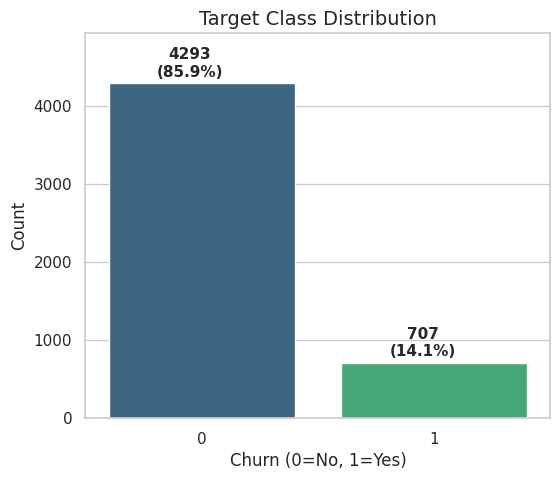

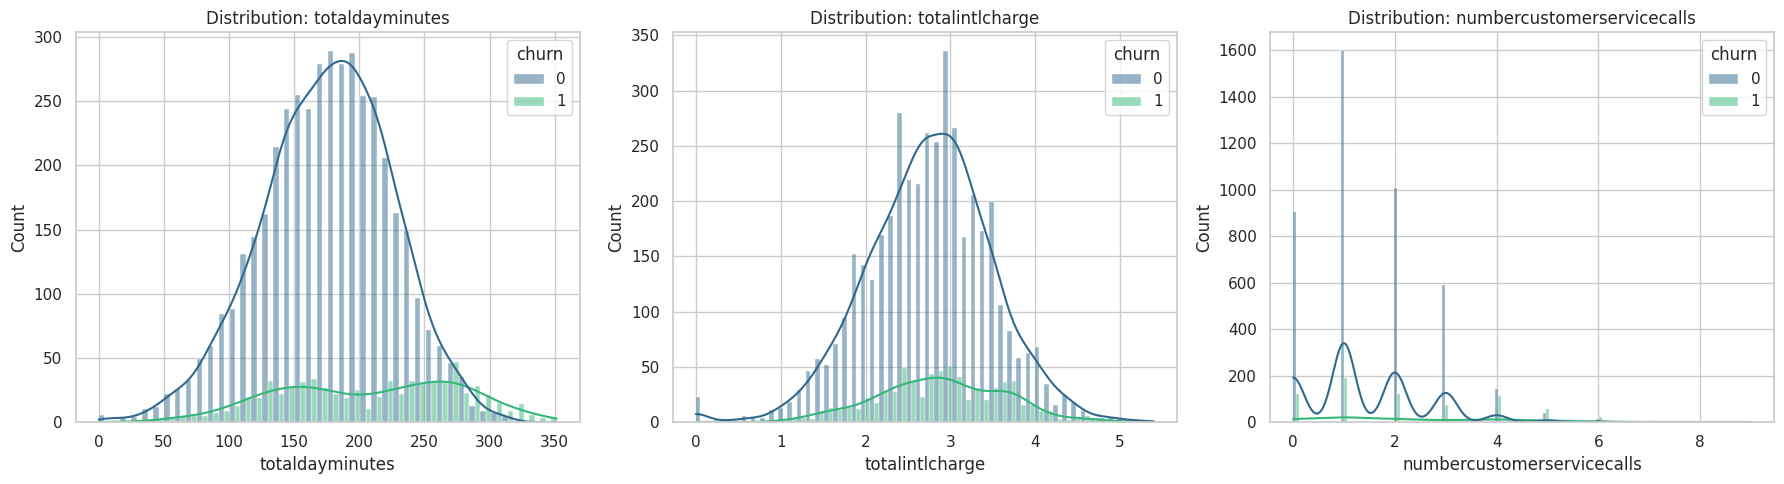

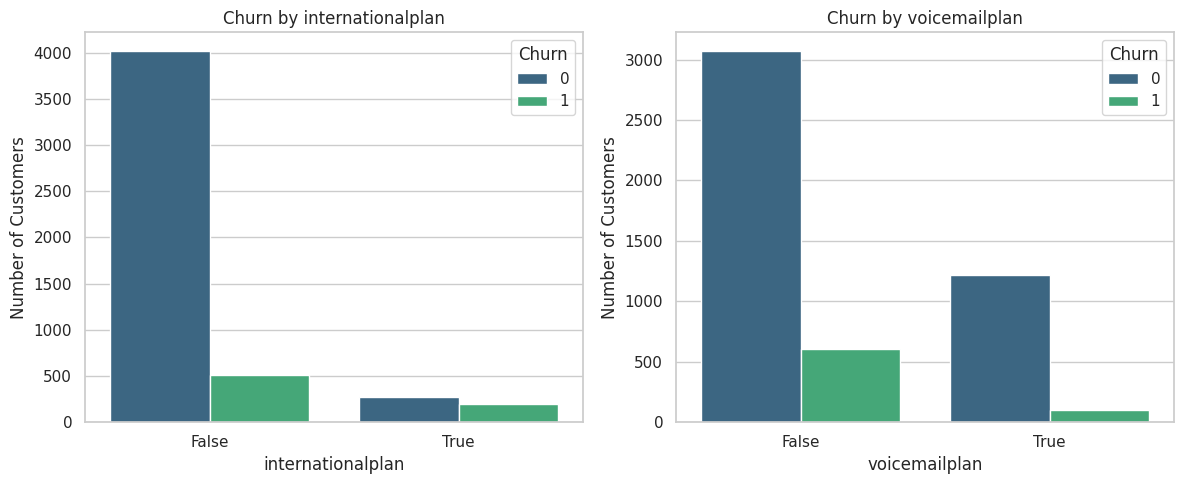

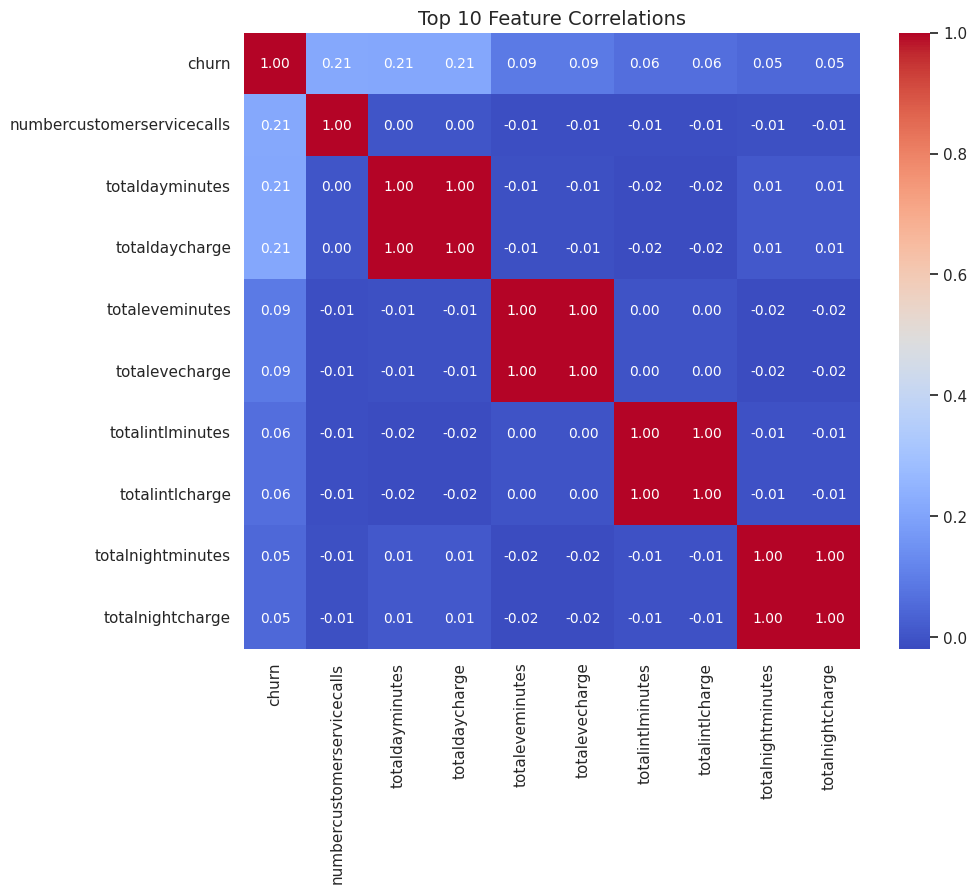

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a clean, standard visual style
sns.set_theme(style="whitegrid")

def run_standard_eda(df, target_col):
    print(f"--- STANDARD EDA FOR: {target_col} ---")

    # 1. CLASS BALANCE (Counts + Percentages)
    plt.figure(figsize=(6, 5))
    ax = sns.countplot(x=df[target_col], palette="viridis")
    plt.title("Target Class Distribution", fontsize=14)
    plt.xlabel("Churn (0=No, 1=Yes)")
    plt.ylabel("Count")

    # Calculate total to compute percentages
    total = len(df)

    # Add labels on top (Count + %)
    for p in ax.patches:
        count = int(p.get_height())
        pct = 100 * count / total
        ax.annotate(f'{count}\n({pct:.1f}%)',
                    (p.get_x() + 0.35, p.get_height() + 50),
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.ylim(0, df[target_col].value_counts().max() * 1.15) # Add headroom for text
    plt.show()

    # 2. NUMERICAL DISTRIBUTIONS (Histograms)
    num_features = ["totaldayminutes", "totalintlcharge", "numbercustomerservicecalls"]
    valid_nums = [c for c in num_features if c in df.columns]

    if valid_nums:
        fig, axes = plt.subplots(1, len(valid_nums), figsize=(18, 5))
        if len(valid_nums) == 1: axes = [axes]

        for ax, feature in zip(axes, valid_nums):
            sns.histplot(data=df, x=feature, hue=target_col, multiple="dodge",
                         kde=True, palette="viridis", ax=ax)
            ax.set_title(f"Distribution: {feature}")

        plt.tight_layout()
        plt.show()

    # 3. CATEGORICAL BREAKDOWN (Grouped Bars)
    cat_features = ["internationalplan", "voicemailplan"]
    valid_cats = [c for c in cat_features if c in df.columns]

    if valid_cats:
        fig, axes = plt.subplots(1, len(valid_cats), figsize=(12, 5))
        if len(valid_cats) == 1: axes = [axes]

        for ax, feature in zip(axes, valid_cats):
            sns.countplot(data=df, x=feature, hue=target_col, palette="viridis", ax=ax)
            ax.set_title(f"Churn by {feature}")
            ax.set_ylabel("Number of Customers")
            ax.legend(title="Churn", loc='upper right')

        plt.tight_layout()
        plt.show()

    # 4. CORRELATION MATRIX
    numeric_df = df.select_dtypes(include=[np.number])
    if numeric_df.shape[1] > 1:
        corr = numeric_df.corr()
        if target_col in corr.columns:
            cols = corr.nlargest(10, target_col)[target_col].index
            cm = np.corrcoef(df[cols].values.T)

            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
                        annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values,
                        cmap="coolwarm")
            plt.title("Top 10 Feature Correlations", fontsize=14)
            plt.show()

# --- EXECUTE ---
df_raw['churn'] = df_raw['churn'].astype(int)
run_standard_eda(df_raw, "churn")

In [ ]:
# ============================================
# FEATURE SELECTION: REMOVE REDUNDANT DATA
# ============================================

# 1. Identify columns to drop
# We drop 'charge' columns because they are 100% correlated with 'minutes'
cols_to_drop = [
    'totaldaycharge',
    'totalevecharge',
    'totalnightcharge',
    'totalintlcharge'
]

print(f"Dropping redundant features: {cols_to_drop}")

# 2. Remove them from the dataframe
df_final = df_raw.drop(columns=cols_to_drop)

# 3. Verify the drop
print(f"New shape: {df_final.shape}")

# RE-DEFINE X AND Y
target_col = 'churn'

# Define X (features) and Y (target) based on the NEW dataframe
X_raw = df_final.drop(columns=[target_col])
Y = df_final[target_col].values.astype(int)

# Re-identify categorical columns (they might still exist)
cat_cols = ['internationalplan', 'voicemailplan']
available_cat_cols = [c for c in cat_cols if c in X_raw.columns]

# Re-Encode
if Encoder == "Label Encoder":
    le = LabelEncoder()
    # Apply encoding to the remaining data
    for col in available_cat_cols:
        X_raw[col] = le.fit_transform(X_raw[col].astype(str))

    X = X_raw.values
else:
    X = X_raw.values

print("Feature selection complete. Redundant columns removed.")

Dropping redundant features: ['totaldaycharge', 'totalevecharge', 'totalnightcharge', 'totalintlcharge']
New shape: (5000, 14)
Feature selection complete. Redundant columns removed.


**Model Definitions**

In [ ]:
# --- A. MLP-Attention (Keras) ---
def feature_attention(inputs, reduction_ratio=4):
    hidden_units = max(1, inputs.shape[-1] // reduction_ratio)
    x = layers.Dense(hidden_units, activation='relu')(inputs)
    x = layers.Dense(inputs.shape[-1], activation='sigmoid')(x)
    return layers.Multiply()([inputs, x])

def build_mlp_att(hp, input_dim):
    hidden_units = hp['hidden_units']
    dropout_rate = hp['dropout_rate']
    lr = hp['learning_rate']
    l2_reg = hp['l2_regularization']

    inputs = layers.Input(shape=(input_dim,))
    x = feature_attention(inputs)

    for units in [hidden_units, hidden_units // 2]:
        x = layers.Dense(units, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    return model

# --- B. FT-Transformer (PyTorch) ---
class FTTransformerPyTorch(nn.Module):
    def __init__(self, input_dim, d_token=128, n_layers=3, n_heads=8, dropout=0.1):
        super(FTTransformerPyTorch, self).__init__()
        self.feature_embeddings = nn.ModuleList([nn.Linear(1, d_token) for _ in range(input_dim)])
        self.layer_norm_input = nn.LayerNorm(d_token)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_token))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_token, nhead=n_heads, dim_feedforward=d_token * 4,
            dropout=dropout, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.classifier = nn.Sequential(
            nn.Linear(d_token, 64), nn.ReLU(), nn.Dropout(dropout), nn.Linear(64, 1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        tokens = [emb(x[:, i].unsqueeze(-1)) for i, emb in enumerate(self.feature_embeddings)]
        x_tokens = torch.stack(tokens, dim=1)
        x_tokens = self.layer_norm_input(x_tokens)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x_tokens = torch.cat([cls_tokens, x_tokens], dim=1)
        x_encoded = self.transformer(x_tokens)
        return self.classifier(x_encoded[:, 0, :])

def train_pytorch_model(model, train_loader, val_loader, epochs, lr, device):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_auc = 0
    patience, counter = 10, 0
    best_state = None

    for epoch in range(epochs):
        model.train()
        for X_b, y_b in train_loader:
            X_b, y_b = X_b.to(device), y_b.to(device).float()
            optimizer.zero_grad()
            loss = criterion(model(X_b).squeeze(), y_b)
            loss.backward()
            optimizer.step()

        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for X_b, y_b in val_loader:
                X_b = X_b.to(device)
                out = model(X_b).squeeze()
                val_preds.extend(torch.sigmoid(out).cpu().numpy())
                val_targets.extend(y_b.numpy())

        auc_score = roc_auc_score(val_targets, val_preds)
        if auc_score > best_auc:
            best_auc = auc_score
            best_state = model.state_dict().copy()
            counter = 0
        else:
            counter += 1
            if counter >= patience: break

    if best_state: model.load_state_dict(best_state)
    return model, best_auc

def predict_pytorch(model, X, device):
    model.eval()
    X_t = torch.FloatTensor(X).to(device)
    with torch.no_grad():
        out = model(X_t).squeeze()
        probs = torch.sigmoid(out).cpu().numpy()
    return probs

**Unified Optuna Tuning**

In [ ]:
def tune_hyperparameters(X, Y, model_type):
    print(f"\nTUNING HYPERPARAMETERS FOR: {model_type}")

    X_tune, X_val, Y_tune, Y_val = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=SEED)
    scaler = StandardScaler()
    X_tune = scaler.fit_transform(X_tune)
    X_val = scaler.transform(X_val)

    sampler = get_sampler(OverSamplingTecnique)
    if sampler: X_tune, Y_tune = sampler.fit_resample(X_tune, Y_tune)

    def objective(trial):
        if model_type == "MLP-Attention":
            tf.keras.backend.clear_session()
            params = {
                'hidden_units': trial.suggest_categorical('hidden_units', [128, 256]),
                'dropout_rate': trial.suggest_float('dropout_rate', 0.2, 0.5),
                'learning_rate': trial.suggest_categorical('learning_rate', [1e-3, 5e-4]),
                'l2_regularization': trial.suggest_float('l2_regularization', 1e-5, 1e-3, log=True)
            }
            model = build_mlp_att(params, X_tune.shape[1])
            early = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
            hist = model.fit(X_tune, Y_tune, validation_data=(X_val, Y_val),
                             epochs=20, batch_size=64, callbacks=[early], verbose=0)
            return max(hist.history['val_AUC'])

        elif model_type == "FT-Transformer":
            d_token = trial.suggest_categorical('d_token', [64, 128])
            n_layers = trial.suggest_int('n_layers', 2, 3)
            dropout = trial.suggest_float('dropout', 0.1, 0.3)
            lr = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
            batch_size = trial.suggest_categorical('batch_size', [64, 128])

            model = FTTransformerPyTorch(X_tune.shape[1], d_token=d_token, n_layers=n_layers, dropout=dropout)

            train_ds = TensorDataset(torch.FloatTensor(X_tune), torch.LongTensor(Y_tune))
            val_ds = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(Y_val))
            train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_ds, batch_size=batch_size)

            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            _, best_auc = train_pytorch_model(model, train_loader, val_loader, 20, lr, device)
            return best_auc

        elif model_type == "TabNet":
            params = {
                'n_d': trial.suggest_int('n_d', 16, 64, step=16),
                'n_a': trial.suggest_int('n_a', 16, 64, step=16),
                'gamma': trial.suggest_float('gamma', 1.0, 1.5),
                'lambda_sparse': trial.suggest_float('lambda_sparse', 1e-4, 1e-2, log=True),
                'lr': trial.suggest_categorical('learning_rate', [0.02, 0.01])
            }
            clf = TabNetClassifier(n_d=params['n_d'], n_a=params['n_a'], gamma=params['gamma'],
                                   lambda_sparse=params['lambda_sparse'],
                                   optimizer_params=dict(lr=params['lr']), verbose=0)
            clf.fit(X_tune, Y_tune, eval_set=[(X_val, Y_val)],
                    max_epochs=20, patience=5, batch_size=256, eval_metric=['auc'])
            val_auc_key = next(k for k in clf.history.history.keys() if "val" in k and "auc" in k)
            return max(clf.history[val_auc_key])

        elif model_type == "XGBoost":
            params = {
                'max_depth': trial.suggest_int('max_depth', 3, 8),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
                'n_estimators': trial.suggest_int('n_estimators', 100, 300),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 5.0),
                'eval_metric': 'auc', 'objective': 'binary:logistic', 'use_label_encoder': False
            }
            model = xgb.XGBClassifier(**params)
            model.fit(X_tune, Y_tune, eval_set=[(X_val, Y_val)], verbose=False)
            return roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])

        elif model_type == "LightGBM":
            params = {
                'num_leaves': trial.suggest_int('num_leaves', 20, 100),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
                'n_estimators': trial.suggest_int('n_estimators', 100, 300),
                'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 5.0),
                'metric': 'auc', 'objective': 'binary', 'verbose': -1
            }
            model = lgb.LGBMClassifier(**params)
            model.fit(X_tune, Y_tune, eval_set=[(X_val, Y_val)], callbacks=[lgb.early_stopping(10, verbose=False)])
            return roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1])

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=TRIALS)
    return study.best_params

**K-Fold Cross-Validation Evaluation**

In [ ]:
def kfold_evaluation(X, Y, best_params, model_type):
    print(f"\nRUNNING K-FOLD CV FOR: {model_type}")

    metrics = defaultdict(list)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Store all predictions for Global ROC
    all_y_true = []
    all_y_prob = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, Y), 1):
        # Changed: Removed 'end=" "' so it prints cleanly, and we will print metrics on the same line
        print(f"Fold {fold}/10...", end=" ")

        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]

        # Scale
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Oversample
        sampler = get_sampler(OverSamplingTecnique)
        if sampler: X_train, Y_train = sampler.fit_resample(X_train, Y_train)

        # Train & Predict
        if model_type == "MLP-Attention":
            model = build_mlp_att(best_params, X_train.shape[1])
            early = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')
            model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early], verbose=0)
            Y_prob = model.predict(X_test, verbose=0).flatten()

        elif model_type == "FT-Transformer":
            model = FTTransformerPyTorch(X_train.shape[1],
                                         d_token=best_params['d_token'],
                                         n_layers=best_params['n_layers'],
                                         dropout=best_params['dropout'])
            train_ds = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(Y_train))
            split = int(0.9 * len(train_ds))
            train_sub, val_sub = torch.utils.data.random_split(train_ds, [split, len(train_ds)-split])
            train_loader = DataLoader(train_sub, batch_size=best_params['batch_size'], shuffle=True)
            val_loader = DataLoader(val_sub, batch_size=best_params['batch_size'])
            model, _ = train_pytorch_model(model, train_loader, val_loader, 100, best_params['learning_rate'], device)
            Y_prob = predict_pytorch(model, X_test, device)

        elif model_type == "TabNet":
            clf = TabNetClassifier(n_d=best_params['n_d'], n_a=best_params['n_a'],
                                   gamma=best_params['gamma'], lambda_sparse=best_params['lambda_sparse'],
                                   optimizer_params=dict(lr=best_params['learning_rate']), verbose=0)
            X_tr, X_val, Y_tr, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=SEED)
            clf.fit(X_tr, Y_tr, eval_set=[(X_val, Y_val)], max_epochs=100, patience=10, batch_size=256)
            Y_prob = clf.predict_proba(X_test)[:, 1]

        elif model_type == "XGBoost":
            p = best_params.copy()
            p.update({'objective': 'binary:logistic', 'eval_metric': 'auc', 'use_label_encoder': False})
            model = xgb.XGBClassifier(**p)
            model.fit(X_train, Y_train, verbose=False)
            Y_prob = model.predict_proba(X_test)[:, 1]

        elif model_type == "LightGBM":
            p = best_params.copy()
            p.update({'objective': 'binary', 'metric': 'auc', 'verbose': -1})
            model = lgb.LGBMClassifier(**p)
            X_tr, X_val, Y_tr, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=SEED)
            callbacks = [lgb.early_stopping(stopping_rounds=10, verbose=False)]
            model.fit(X_tr, Y_tr, eval_set=[(X_val, Y_val)], eval_metric='auc', callbacks=callbacks)
            Y_prob = model.predict_proba(X_test)[:, 1]

        # Aggregate Metrics
        Y_pred = np.round(Y_prob).astype(int)
        metrics['accuracy'].append(accuracy_score(Y_test, Y_pred))
        metrics['f1'].append(f1_score(Y_test, Y_pred))
        metrics['auc'].append(roc_auc_score(Y_test, Y_prob))
        metrics['precision'].append(precision_score(Y_test, Y_pred, zero_division=0))
        metrics['recall'].append(recall_score(Y_test, Y_pred, zero_division=0))
        metrics['mcc'].append(matthews_corrcoef(Y_test, Y_pred))

        # Collect for ROC Plot
        all_y_true.extend(Y_test)
        all_y_prob.extend(Y_prob)

        # --- RESTORED PRINT STATEMENT ---
        print(f"Acc: {metrics['accuracy'][-1]:.4f} | F1: {metrics['f1'][-1]:.4f} | AUC: {metrics['auc'][-1]:.4f}")

    print(f"\nAverage F1 across all folds: {np.mean(metrics['f1']):.4f}")

    # Return metrics AND aggregated predictions for plotting
    avg_metrics = {k: np.mean(v) for k, v in metrics.items()}
    return avg_metrics, np.array(all_y_true), np.array(all_y_prob)

**Main**

In [ ]:
if __name__ == "__main__":

    # --- CONFIGURATION SWITCH ---
    RUN_MODE = "All"  # "Single" or "All"
    ALL_MODELS = ["MLP-Attention", "FT-Transformer", "TabNet", "XGBoost", "LightGBM"]
    # ----------------------------

    results_summary = {}
    roc_data = {} # Store data for ROC curves

    models_to_run = [MODEL_TYPE] if RUN_MODE == "Single" else ALL_MODELS

    if RUN_MODE == "All":
        print(f"\nSTARTING BENCHMARK ON ALL MODELS: {models_to_run}")

    for current_model in models_to_run:
        print("\n" + "#"*60)
        print(f"PIPELINE: {current_model}")
        print("#"*60)

        try:
            # 1. Tune
            best_params = tune_hyperparameters(X, Y, current_model)
            print(f"Best Params: {best_params}")

            # 2. Evaluate (Now returns y_true and y_prob too)
            final_metrics, y_true, y_prob = kfold_evaluation(X, Y, best_params, current_model)

            results_summary[current_model] = final_metrics
            roc_data[current_model] = (y_true, y_prob)

        except Exception as e:
            print(f"FAILED: {current_model} crashed with error: {e}")
            import traceback
            traceback.print_exc()

[I 2026-01-10 18:44:30,072] A new study created in memory with name: no-name-191c7ffd-ff49-401c-a778-9f031e7391b5



STARTING BENCHMARK ON ALL MODELS: ['MLP-Attention', 'FT-Transformer', 'TabNet', 'XGBoost', 'LightGBM']

############################################################
PIPELINE: MLP-Attention
############################################################

TUNING HYPERPARAMETERS FOR: MLP-Attention


[I 2026-01-10 18:45:04,464] Trial 0 finished with value: 0.9146046042442322 and parameters: {'hidden_units': 256, 'dropout_rate': 0.28760846730759765, 'learning_rate': 0.0005, 'l2_regularization': 0.0001748346871589614}. Best is trial 0 with value: 0.9146046042442322.
[I 2026-01-10 18:45:23,098] Trial 1 finished with value: 0.9226711392402649 and parameters: {'hidden_units': 128, 'dropout_rate': 0.28137819744917475, 'learning_rate': 0.0005, 'l2_regularization': 0.0005720968743498537}. Best is trial 1 with value: 0.9226711392402649.
[I 2026-01-10 18:45:40,187] Trial 2 finished with value: 0.9223944544792175 and parameters: {'hidden_units': 128, 'dropout_rate': 0.32805902771523276, 'learning_rate': 0.001, 'l2_regularization': 7.746998212841519e-05}. Best is trial 1 with value: 0.9226711392402649.
[I 2026-01-10 18:45:58,330] Trial 3 finished with value: 0.9189516305923462 and parameters: {'hidden_units': 256, 'dropout_rate': 0.32879741340140106, 'learning_rate': 0.0005, 'l2_regularization

Best Params: {'hidden_units': 128, 'dropout_rate': 0.24567527362917013, 'learning_rate': 0.001, 'l2_regularization': 0.00015422244594750129}

RUNNING K-FOLD CV FOR: MLP-Attention
Fold 1/10... Acc: 0.9340 | F1: 0.7692 | AUC: 0.9125
Fold 2/10... Acc: 0.9400 | F1: 0.7917 | AUC: 0.9061
Fold 3/10... Acc: 0.9500 | F1: 0.8276 | AUC: 0.9482
Fold 4/10... Acc: 0.9440 | F1: 0.8133 | AUC: 0.9336
Fold 5/10... Acc: 0.9160 | F1: 0.7529 | AUC: 0.9499
Fold 6/10... Acc: 0.9120 | F1: 0.7317 | AUC: 0.9204
Fold 7/10... Acc: 0.9420 | F1: 0.8054 | AUC: 0.9296
Fold 8/10... Acc: 0.9260 | F1: 0.7517 | AUC: 0.9107
Fold 9/10... Acc: 0.9380 | F1: 0.7832 | AUC: 0.9190
Fold 10/10... 

[I 2026-01-10 19:03:59,789] A new study created in memory with name: no-name-b393eb97-9807-4fad-85d5-bd963cd7554c


Acc: 0.9400 | F1: 0.7826 | AUC: 0.9084

Average F1 across all folds: 0.7809

############################################################
PIPELINE: FT-Transformer
############################################################

TUNING HYPERPARAMETERS FOR: FT-Transformer


[I 2026-01-10 19:04:15,203] Trial 0 finished with value: 0.9323062442721621 and parameters: {'d_token': 128, 'n_layers': 2, 'dropout': 0.2319333585046761, 'learning_rate': 0.0009907532537425045, 'batch_size': 128}. Best is trial 0 with value: 0.9323062442721621.
[I 2026-01-10 19:04:25,702] Trial 1 finished with value: 0.9205492119320668 and parameters: {'d_token': 64, 'n_layers': 2, 'dropout': 0.19543396390542642, 'learning_rate': 0.00016102901095567504, 'batch_size': 128}. Best is trial 0 with value: 0.9323062442721621.
[I 2026-01-10 19:04:38,648] Trial 2 finished with value: 0.9243058479677012 and parameters: {'d_token': 64, 'n_layers': 3, 'dropout': 0.23577918663575476, 'learning_rate': 0.00049692454053681, 'batch_size': 128}. Best is trial 0 with value: 0.9323062442721621.
[I 2026-01-10 19:04:51,666] Trial 3 finished with value: 0.9323888077015167 and parameters: {'d_token': 128, 'n_layers': 3, 'dropout': 0.22212565562871783, 'learning_rate': 0.0002556494374643722, 'batch_size': 12

Best Params: {'d_token': 128, 'n_layers': 3, 'dropout': 0.2950460973361301, 'learning_rate': 0.0009839404554346685, 'batch_size': 64}

RUNNING K-FOLD CV FOR: FT-Transformer
Fold 1/10... Acc: 0.9580 | F1: 0.8489 | AUC: 0.9224
Fold 2/10... Acc: 0.9380 | F1: 0.7947 | AUC: 0.9242
Fold 3/10... Acc: 0.9140 | F1: 0.7296 | AUC: 0.9128
Fold 4/10... Acc: 0.9100 | F1: 0.7273 | AUC: 0.9233
Fold 5/10... Acc: 0.9640 | F1: 0.8767 | AUC: 0.9579
Fold 6/10... Acc: 0.9160 | F1: 0.7342 | AUC: 0.9381
Fold 7/10... Acc: 0.9540 | F1: 0.8392 | AUC: 0.9216
Fold 8/10... Acc: 0.9300 | F1: 0.7586 | AUC: 0.8863
Fold 9/10... Acc: 0.9580 | F1: 0.8489 | AUC: 0.9103
Fold 10/10... 

[I 2026-01-10 19:21:23,664] A new study created in memory with name: no-name-28525ba8-b9ce-43ae-80f5-924ad54314c8


Acc: 0.9320 | F1: 0.7463 | AUC: 0.8644

Average F1 across all folds: 0.7904

############################################################
PIPELINE: TabNet
############################################################

TUNING HYPERPARAMETERS FOR: TabNet

Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_auc = 0.90055


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:21:31,697] Trial 0 finished with value: 0.9005523493423823 and parameters: {'n_d': 64, 'n_a': 64, 'gamma': 1.239662764616253, 'lambda_sparse': 0.00044012737321941816, 'learning_rate': 0.01}. Best is trial 0 with value: 0.9005523493423823.



Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_0_auc = 0.89416


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:21:38,829] Trial 1 finished with value: 0.8941619399103361 and parameters: {'n_d': 64, 'n_a': 16, 'gamma': 1.045489220822675, 'lambda_sparse': 0.00011429093300404736, 'learning_rate': 0.02}. Best is trial 0 with value: 0.9005523493423823.



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_auc = 0.91325


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:21:44,737] Trial 2 finished with value: 0.9132506047771201 and parameters: {'n_d': 48, 'n_a': 48, 'gamma': 1.174764665678602, 'lambda_sparse': 0.0004416205418154958, 'learning_rate': 0.01}. Best is trial 2 with value: 0.9132506047771201.



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_auc = 0.90935


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:21:53,772] Trial 3 finished with value: 0.9093536109115827 and parameters: {'n_d': 48, 'n_a': 64, 'gamma': 1.082317912665386, 'lambda_sparse': 0.00655606812428064, 'learning_rate': 0.02}. Best is trial 2 with value: 0.9132506047771201.



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_auc = 0.91097


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:22:02,947] Trial 4 finished with value: 0.9109718541269329 and parameters: {'n_d': 16, 'n_a': 16, 'gamma': 1.3752494590192073, 'lambda_sparse': 0.0037471213294192488, 'learning_rate': 0.02}. Best is trial 2 with value: 0.9132506047771201.



Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_0_auc = 0.89797


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:22:09,533] Trial 5 finished with value: 0.8979681140035833 and parameters: {'n_d': 64, 'n_a': 32, 'gamma': 1.3209458037227326, 'lambda_sparse': 0.002454297312069004, 'learning_rate': 0.02}. Best is trial 2 with value: 0.9132506047771201.


Stop training because you reached max_epochs = 20 with best_epoch = 16 and best_val_0_auc = 0.91264


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:22:23,156] Trial 6 finished with value: 0.912639635399896 and parameters: {'n_d': 48, 'n_a': 32, 'gamma': 1.2953762144854104, 'lambda_sparse': 0.007008892652118492, 'learning_rate': 0.01}. Best is trial 2 with value: 0.9132506047771201.



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_auc = 0.87434


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:22:32,293] Trial 7 finished with value: 0.8743384605222964 and parameters: {'n_d': 48, 'n_a': 64, 'gamma': 1.145105910558975, 'lambda_sparse': 0.0038615370953450404, 'learning_rate': 0.01}. Best is trial 2 with value: 0.9132506047771201.



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_0_auc = 0.93075


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:22:43,777] Trial 8 finished with value: 0.9307540518002956 and parameters: {'n_d': 32, 'n_a': 64, 'gamma': 1.2666880362553032, 'lambda_sparse': 0.00973417090264752, 'learning_rate': 0.02}. Best is trial 8 with value: 0.9307540518002956.


Stop training because you reached max_epochs = 20 with best_epoch = 16 and best_val_0_auc = 0.91405


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:22:57,279] Trial 9 finished with value: 0.9140514700418597 and parameters: {'n_d': 32, 'n_a': 16, 'gamma': 1.1582011514800232, 'lambda_sparse': 0.007659747036462459, 'learning_rate': 0.01}. Best is trial 8 with value: 0.9307540518002956.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_auc = 0.90821


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:23:04,863] Trial 10 finished with value: 0.9082059792435538 and parameters: {'n_d': 16, 'n_a': 48, 'gamma': 1.4589303986447444, 'lambda_sparse': 0.0010594579218796672, 'learning_rate': 0.02}. Best is trial 8 with value: 0.9307540518002956.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_auc = 0.88939


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:23:12,589] Trial 11 finished with value: 0.8893897736936401 and parameters: {'n_d': 32, 'n_a': 32, 'gamma': 1.2089286411933633, 'lambda_sparse': 0.009552796002782441, 'learning_rate': 0.01}. Best is trial 8 with value: 0.9307540518002956.



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_auc = 0.90754


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:23:21,112] Trial 12 finished with value: 0.9075372154657816 and parameters: {'n_d': 32, 'n_a': 48, 'gamma': 1.1192311121269563, 'lambda_sparse': 0.0017814947937934286, 'learning_rate': 0.01}. Best is trial 8 with value: 0.9307540518002956.



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_0_auc = 0.90941


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:23:33,311] Trial 13 finished with value: 0.9094114053121309 and parameters: {'n_d': 32, 'n_a': 16, 'gamma': 1.3753688745092123, 'lambda_sparse': 0.009477524342465075, 'learning_rate': 0.02}. Best is trial 8 with value: 0.9307540518002956.



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_auc = 0.90544


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:23:42,316] Trial 14 finished with value: 0.9054401043601747 and parameters: {'n_d': 16, 'n_a': 48, 'gamma': 1.2661298754609174, 'lambda_sparse': 0.003101422982135684, 'learning_rate': 0.01}. Best is trial 8 with value: 0.9307540518002956.



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_auc = 0.91825


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:23:51,891] Trial 15 finished with value: 0.9182456922530734 and parameters: {'n_d': 32, 'n_a': 32, 'gamma': 1.202604740423273, 'lambda_sparse': 0.0013097973129257148, 'learning_rate': 0.02}. Best is trial 8 with value: 0.9307540518002956.



Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_0_auc = 0.9066


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:24:02,803] Trial 16 finished with value: 0.906595992371139 and parameters: {'n_d': 32, 'n_a': 32, 'gamma': 1.3562365722785252, 'lambda_sparse': 0.00035451751711608405, 'learning_rate': 0.02}. Best is trial 8 with value: 0.9307540518002956.



Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_0_auc = 0.90709


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:24:09,435] Trial 17 finished with value: 0.9070913729472668 and parameters: {'n_d': 16, 'n_a': 64, 'gamma': 1.0025189969458697, 'lambda_sparse': 0.0008539073617022291, 'learning_rate': 0.02}. Best is trial 8 with value: 0.9307540518002956.



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_0_auc = 0.8975


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:24:17,787] Trial 18 finished with value: 0.8975016306277298 and parameters: {'n_d': 32, 'n_a': 48, 'gamma': 1.449732318004062, 'lambda_sparse': 0.00012531404180661165, 'learning_rate': 0.02}. Best is trial 8 with value: 0.9307540518002956.



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_auc = 0.91645


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:24:27,340] Trial 19 finished with value: 0.9164540658360786 and parameters: {'n_d': 48, 'n_a': 32, 'gamma': 1.2167148875649916, 'lambda_sparse': 0.0002483768172532235, 'learning_rate': 0.02}. Best is trial 8 with value: 0.9307540518002956.



Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_0_auc = 0.91302


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:24:38,352] Trial 20 finished with value: 0.9130194271749271 and parameters: {'n_d': 16, 'n_a': 64, 'gamma': 1.281489832031624, 'lambda_sparse': 0.0011062927493084335, 'learning_rate': 0.02}. Best is trial 8 with value: 0.9307540518002956.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_auc = 0.89786


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:24:45,545] Trial 21 finished with value: 0.8978607815454223 and parameters: {'n_d': 48, 'n_a': 32, 'gamma': 1.212222537490634, 'lambda_sparse': 0.00023148578567587063, 'learning_rate': 0.02}. Best is trial 8 with value: 0.9307540518002956.



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_0_auc = 0.90677


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:24:53,938] Trial 22 finished with value: 0.9067693755727837 and parameters: {'n_d': 32, 'n_a': 32, 'gamma': 1.2118432492043765, 'lambda_sparse': 0.00021023044445259089, 'learning_rate': 0.02}. Best is trial 8 with value: 0.9307540518002956.



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_0_auc = 0.91046


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:25:02,378] Trial 23 finished with value: 0.9104599608649345 and parameters: {'n_d': 48, 'n_a': 32, 'gamma': 1.3185298632206202, 'lambda_sparse': 0.0006794761611637925, 'learning_rate': 0.02}. Best is trial 8 with value: 0.9307540518002956.



Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_0_auc = 0.90931


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:25:09,076] Trial 24 finished with value: 0.9093123291969055 and parameters: {'n_d': 32, 'n_a': 48, 'gamma': 1.1159973139845731, 'lambda_sparse': 0.0016153116297704746, 'learning_rate': 0.02}. Best is trial 8 with value: 0.9307540518002956.


Stop training because you reached max_epochs = 20 with best_epoch = 18 and best_val_0_auc = 0.91057


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:25:22,800] Trial 25 finished with value: 0.9105672933230954 and parameters: {'n_d': 48, 'n_a': 32, 'gamma': 1.1930008372876117, 'lambda_sparse': 0.0001925070172798881, 'learning_rate': 0.02}. Best is trial 8 with value: 0.9307540518002956.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_auc = 0.89565


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:25:30,293] Trial 26 finished with value: 0.8956522098101867 and parameters: {'n_d': 32, 'n_a': 16, 'gamma': 1.2369836057657777, 'lambda_sparse': 0.005061867821437754, 'learning_rate': 0.02}. Best is trial 8 with value: 0.9307540518002956.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_auc = 0.91279


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:25:38,151] Trial 27 finished with value: 0.9127882495727343 and parameters: {'n_d': 48, 'n_a': 48, 'gamma': 1.4017502246904872, 'lambda_sparse': 0.0016382171456923076, 'learning_rate': 0.02}. Best is trial 8 with value: 0.9307540518002956.



Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_0_auc = 0.9182


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:25:49,070] Trial 28 finished with value: 0.9181961541954607 and parameters: {'n_d': 64, 'n_a': 32, 'gamma': 1.237369508025364, 'lambda_sparse': 0.0005932048434437059, 'learning_rate': 0.02}. Best is trial 8 with value: 0.9307540518002956.



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_0_auc = 0.92229


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:26:00,486] Trial 29 finished with value: 0.922291300291449 and parameters: {'n_d': 64, 'n_a': 64, 'gamma': 1.2446297323961586, 'lambda_sparse': 0.0004575450238484783, 'learning_rate': 0.02}. Best is trial 8 with value: 0.9307540518002956.


Best Params: {'n_d': 32, 'n_a': 64, 'gamma': 1.2666880362553032, 'lambda_sparse': 0.00973417090264752, 'learning_rate': 0.02}

RUNNING K-FOLD CV FOR: TabNet
Fold 1/10... 
Early stopping occurred at epoch 46 with best_epoch = 36 and best_val_0_auc = 0.98198


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Acc: 0.9300 | F1: 0.7552 | AUC: 0.8929
Fold 2/10... 
Early stopping occurred at epoch 47 with best_epoch = 37 and best_val_0_auc = 0.98493


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Acc: 0.9340 | F1: 0.7815 | AUC: 0.9192
Fold 3/10... 
Early stopping occurred at epoch 50 with best_epoch = 40 and best_val_0_auc = 0.99062


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Acc: 0.9160 | F1: 0.7237 | AUC: 0.9255
Fold 4/10... 
Early stopping occurred at epoch 40 with best_epoch = 30 and best_val_0_auc = 0.98012


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Acc: 0.9020 | F1: 0.7101 | AUC: 0.9129
Fold 5/10... 
Early stopping occurred at epoch 72 with best_epoch = 62 and best_val_0_auc = 0.99107


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Acc: 0.9120 | F1: 0.7250 | AUC: 0.9087
Fold 6/10... 
Early stopping occurred at epoch 56 with best_epoch = 46 and best_val_0_auc = 0.99655


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Acc: 0.9180 | F1: 0.7355 | AUC: 0.9065
Fold 7/10... 
Early stopping occurred at epoch 82 with best_epoch = 72 and best_val_0_auc = 0.98967


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Acc: 0.9420 | F1: 0.7943 | AUC: 0.9132
Fold 8/10... 
Early stopping occurred at epoch 82 with best_epoch = 72 and best_val_0_auc = 0.99642


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Acc: 0.9040 | F1: 0.6757 | AUC: 0.8643
Fold 9/10... 
Early stopping occurred at epoch 74 with best_epoch = 64 and best_val_0_auc = 0.99206


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Acc: 0.9280 | F1: 0.7429 | AUC: 0.8634
Fold 10/10... 
Early stopping occurred at epoch 92 with best_epoch = 82 and best_val_0_auc = 0.9955


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2026-01-10 19:33:30,880] A new study created in memory with name: no-name-f04362e4-7fdd-43c7-a327-56941cb9e401


Acc: 0.9140 | F1: 0.7152 | AUC: 0.8897

Average F1 across all folds: 0.7359

############################################################
PIPELINE: XGBoost
############################################################

TUNING HYPERPARAMETERS FOR: XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:33:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2026-01-10 19:33:31,170] Trial 0 finished with value: 0.9286156589800113 and parameters: {'max_depth': 4, 'learning_rate': 0.13547652039294986, 'n_estimators': 160, 'subsample': 0.8598927333512147, 'scale_pos_weight': 1.639503902967542}. Best is trial 0 with value: 0.9286156589800113.
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:33:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2026-01-10 19:33:31,793] Trial 1 finished with value: 0.927154286280435 and parameters: {'max_depth': 7, 'learning_rate': 0.07208447077973253, 'n_estimators': 220, 'subsample': 0.6633209834232484, 'scale_pos_weight': 1.853142120204153}. Best is trial 0 with 

Best Params: {'max_depth': 5, 'learning_rate': 0.1413319798931257, 'n_estimators': 141, 'subsample': 0.855528573853767, 'scale_pos_weight': 1.6537130988925592}

RUNNING K-FOLD CV FOR: XGBoost
Fold 1/10... Acc: 0.9620 | F1: 0.8613 | AUC: 0.9148
Fold 2/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:33:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Acc: 0.9520 | F1: 0.8356 | AUC: 0.9120
Fold 3/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:33:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Acc: 0.9620 | F1: 0.8593 | AUC: 0.9447
Fold 4/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:33:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Acc: 0.9540 | F1: 0.8414 | AUC: 0.9182
Fold 5/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:33:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Acc: 0.9640 | F1: 0.8750 | AUC: 0.9549
Fold 6/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:33:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Acc: 0.9440 | F1: 0.7971 | AUC: 0.9158
Fold 7/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:33:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Acc: 0.9600 | F1: 0.8529 | AUC: 0.9188
Fold 8/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:33:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Acc: 0.9460 | F1: 0.8000 | AUC: 0.8909
Fold 9/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:33:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Acc: 0.9580 | F1: 0.8489 | AUC: 0.8891
Fold 10/10... 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:33:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2026-01-10 19:33:47,745] A new study created in memory with name: no-name-08e4d308-9c1b-4171-8e83-95a322d8af4a


Acc: 0.9420 | F1: 0.7943 | AUC: 0.8894

Average F1 across all folds: 0.8366

############################################################
PIPELINE: LightGBM
############################################################

TUNING HYPERPARAMETERS FOR: LightGBM


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2026-01-10 19:33:48,103] Trial 0 finished with value: 0.9308201025437793 and parameters: {'num_leaves': 37, 'max_depth': 10, 'learning_rate': 0.1776060974682636, 'n_estimators': 159, 'scale_pos_weight': 4.550057462194211}. Best is trial 0 with value: 0.9308201025437793.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2026-01-10 19:33:48,516] Trial 1 finished with value: 0.9300687753366524 and parameters: {'num_leaves': 62, 'max_depth': 10, 'learning_rate': 0.1390034546275612, 'n_estimators': 198, 'scale_pos_weight': 1.7446011000840502}. Best is trial 0 with value: 0.9308201025437793.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:273

Best Params: {'num_leaves': 47, 'max_depth': 9, 'learning_rate': 0.19939371166301123, 'n_estimators': 160, 'scale_pos_weight': 3.1430580197136297}

RUNNING K-FOLD CV FOR: LightGBM
Fold 1/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acc: 0.9540 | F1: 0.8369 | AUC: 0.9185
Fold 2/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acc: 0.9480 | F1: 0.8194 | AUC: 0.8978
Fold 3/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acc: 0.9600 | F1: 0.8462 | AUC: 0.9410
Fold 4/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acc: 0.9700 | F1: 0.8905 | AUC: 0.9203
Fold 5/10... Acc: 0.9620 | F1: 0.8690 | AUC: 0.9517
Fold 6/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acc: 0.9400 | F1: 0.7857 | AUC: 0.9171
Fold 7/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acc: 0.9600 | F1: 0.8507 | AUC: 0.9192
Fold 8/10... Acc: 0.9260 | F1: 0.7338 | AUC: 0.9056


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 9/10... 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acc: 0.9580 | F1: 0.8467 | AUC: 0.8942
Fold 10/10... Acc: 0.9500 | F1: 0.8175 | AUC: 0.9053

Average F1 across all folds: 0.8296


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


**Visualization Of Results**



FINAL CHAMPIONSHIP LEADERBOARD
                accuracy        f1       auc  precision    recall       mcc
XGBoost           0.9544  0.836586  0.914859   0.848747  0.826117  0.810668
LightGBM          0.9528  0.829646  0.917088   0.849968  0.811932  0.803134
FT-Transformer    0.9374  0.790432  0.916119   0.764367  0.824688  0.756607
MLP-Attention     0.9342  0.780934  0.923859   0.745840  0.824588  0.745355
TabNet            0.9200  0.735902  0.899633   0.695933  0.785070  0.692140
WINNER: XGBoost


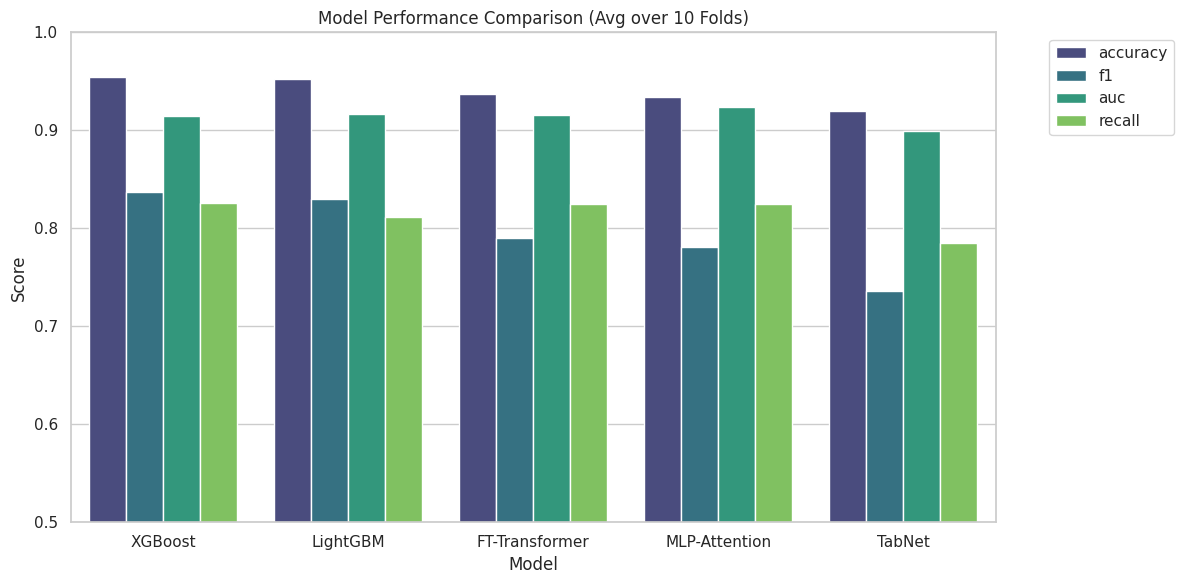

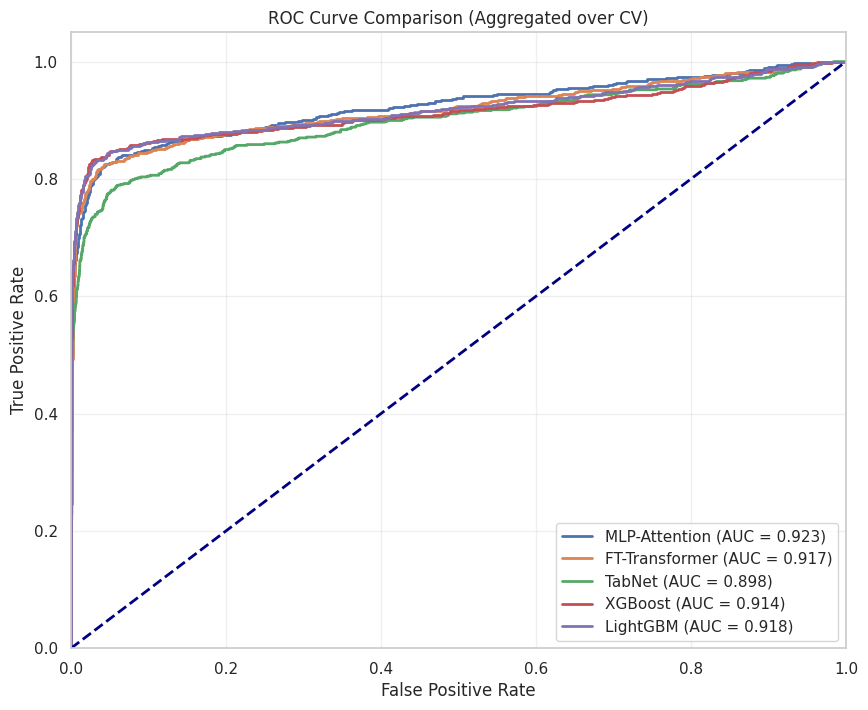

In [ ]:
if len(results_summary) > 0:
        print("\n\n" + "="*80)
        print("FINAL CHAMPIONSHIP LEADERBOARD")
        print("="*80)

        df_results = pd.DataFrame(results_summary).T
        if "f1" in df_results.columns:
            df_results = df_results.sort_values(by="f1", ascending=False)
        print(df_results)
        print("="*80)
        print(f"WINNER: {df_results.index[0]}")

        # --- PLOT 1: Performance Metrics Comparison ---
        plt.figure(figsize=(12, 6))
        # Melt dataframe for seaborn
        df_melted = df_results.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
        # Filter for key metrics to avoid clutter
        key_metrics = ['accuracy', 'f1', 'auc', 'recall']
        df_melted = df_melted[df_melted['Metric'].isin(key_metrics)]

        sns.barplot(data=df_melted, x='index', y='Score', hue='Metric', palette='viridis')
        plt.title('Model Performance Comparison (Avg over 10 Folds)')
        plt.xlabel('Model')
        plt.ylabel('Score')
        plt.ylim(0.5, 1.0) # Zoom in on the top half
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        # --- PLOT 2: ROC Curves ---
        plt.figure(figsize=(10, 8))
        for name, (y_t, y_p) in roc_data.items():
            fpr, tpr, _ = roc_curve(y_t, y_p)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve Comparison (Aggregated over CV)')
        plt.legend(loc="lower right")
        plt.grid(alpha=0.3)
        plt.show()

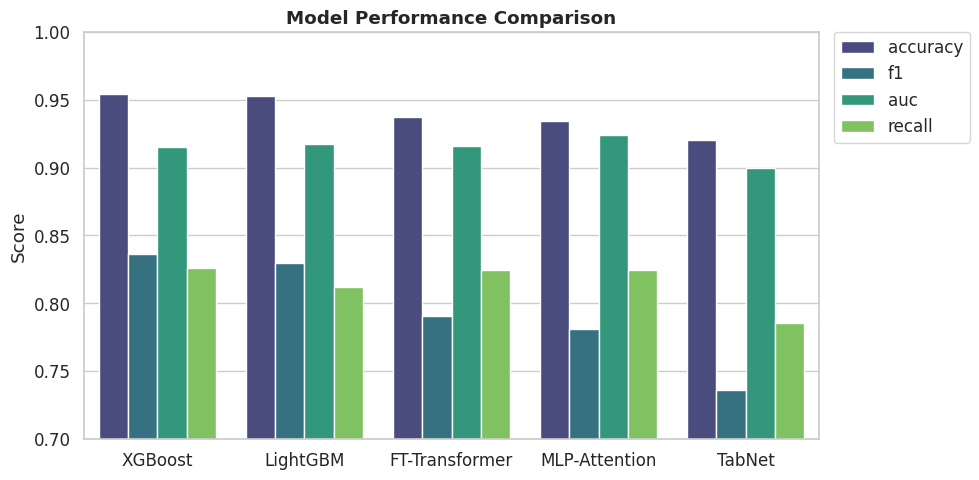

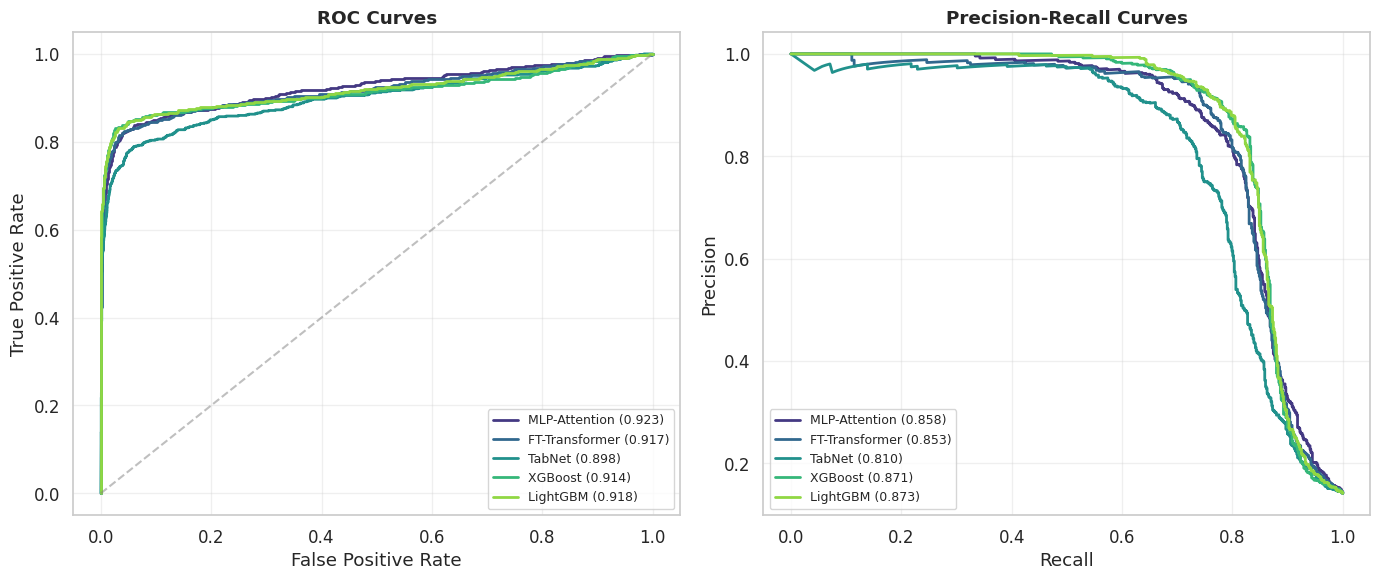

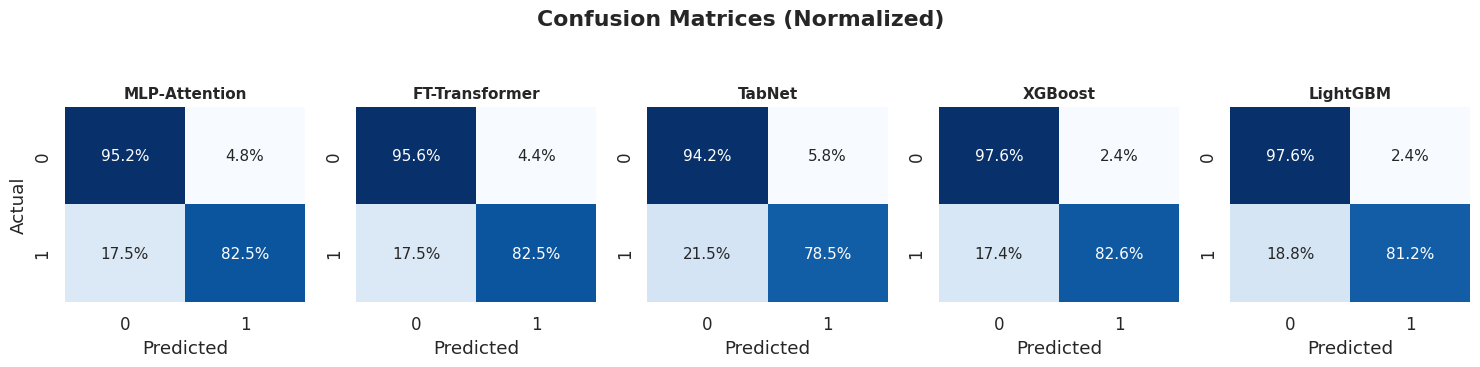

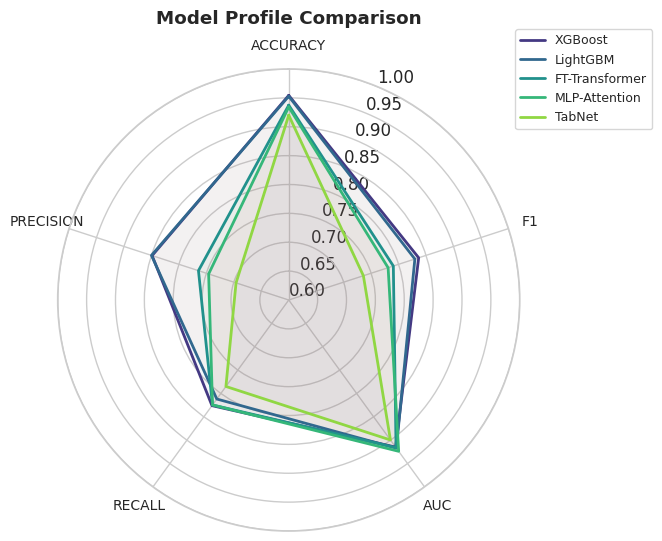

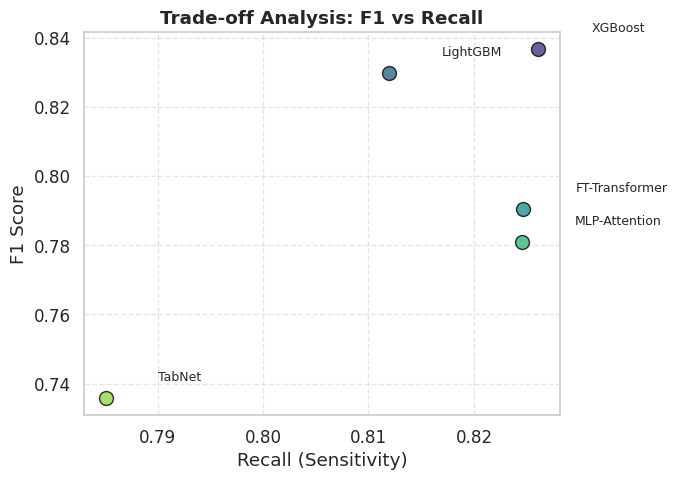

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from math import pi
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

# --- 1. SETUP STYLE FOR PAPER ---
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1) # Cleaner, smaller fonts
palette = sns.color_palette("viridis", n_colors=len(roc_data))

# --------------------------------------------
# 1. CLEAN METRIC BAR PLOT (COMPACT)
# --------------------------------------------
plt.figure(figsize=(10, 5)) # Much smaller, cleaner size

# Reshape data for Seaborn
df_melted = df_results[['accuracy', 'f1', 'auc', 'recall']].reset_index().melt(
    id_vars='index', var_name='Metric', value_name='Score'
)

ax = sns.barplot(
    data=df_melted,
    x='index',
    y='Score',
    hue='Metric',
    palette='viridis'
)

plt.title("Model Performance Comparison", fontweight='bold')
plt.xlabel("") # Remove 'Model' label (names are enough)
plt.ylabel("Score")
plt.ylim(0.7, 1.0) # Zoom in on the relevant range
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

# --------------------------------------------
# 2. ROC & PRECISION-RECALL (SIDE-BY-SIDE)
# --------------------------------------------
# Combining these into one figure saves space in a paper
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Left: ROC Curve ---
for i, (model_name, (y_true, y_prob)) in enumerate(roc_data.items()):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, lw=2, color=palette[i], label=f"{model_name} ({roc_auc:.3f})")

axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.5)
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curves", fontweight="bold")
axes[0].legend(loc="lower right", fontsize=9)
axes[0].grid(alpha=0.3)

# --- Right: Precision-Recall ---
for i, (model_name, (y_true, y_prob)) in enumerate(roc_data.items()):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    axes[1].plot(recall, precision, lw=2, color=palette[i], label=f"{model_name} ({pr_auc:.3f})")

axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curves", fontweight="bold")
axes[1].legend(loc="lower left", fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --------------------------------------------
# 3. NORMALIZED CONFUSION MATRICES (GRID)
# --------------------------------------------
n_models = len(roc_data)
# Dynamic sizing: 3 inches wide per subplot
fig, axes = plt.subplots(1, n_models, figsize=(3 * n_models, 3.5))

if n_models == 1: axes = [axes]

for ax, (model_name, (y_true, y_prob)) in zip(axes, roc_data.items()):
    y_pred = (y_prob >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    sns.heatmap(
        cm,
        annot=True,
        fmt=".1%", # Show as percentages (easier to read)
        cmap="Blues",
        cbar=False,
        ax=ax,
        annot_kws={"size": 11}
    )
    ax.set_title(model_name, fontsize=11, fontweight='bold')
    ax.set_xlabel("Predicted")
    if ax == axes[0]: ax.set_ylabel("Actual") # Only show Y label on first plot
    else: ax.set_ylabel("")

plt.suptitle("Confusion Matrices (Normalized)", y=1.05, fontweight="bold")
plt.tight_layout()
plt.show()

# --------------------------------------------
# 4. RADAR CHART (COMPACT)
# --------------------------------------------
metrics_for_radar = ['accuracy', 'f1', 'auc', 'recall', 'precision']
labels = [m.upper() for m in metrics_for_radar]
num_vars = len(labels)

angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for i, model in enumerate(df_results.index):
    values = df_results.loc[model, metrics_for_radar].values.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model, color=palette[i])
    ax.fill(angles, values, alpha=0.05)

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, size=10)
ax.set_ylim(0.6, 1.0) # Zoom in to show differences
plt.title("Model Profile Comparison", fontweight="bold", y=1.08)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
plt.show()

# --------------------------------------------
# 5. F1 vs RECALL TRADEOFF
# --------------------------------------------
plt.figure(figsize=(7, 5))

for i, model in enumerate(df_results.index):
    x = df_results.loc[model, 'recall']
    y = df_results.loc[model, 'f1']

    plt.scatter(x, y, s=100, color=palette[i], edgecolors='black', label=model, alpha=0.8)

    # Smart labelling to avoid overlap
    plt.text(x + 0.005, y + 0.005, model, fontsize=9)

plt.xlabel("Recall (Sensitivity)")
plt.ylabel("F1 Score")
plt.title("Trade-off Analysis: F1 vs Recall", fontweight="bold")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

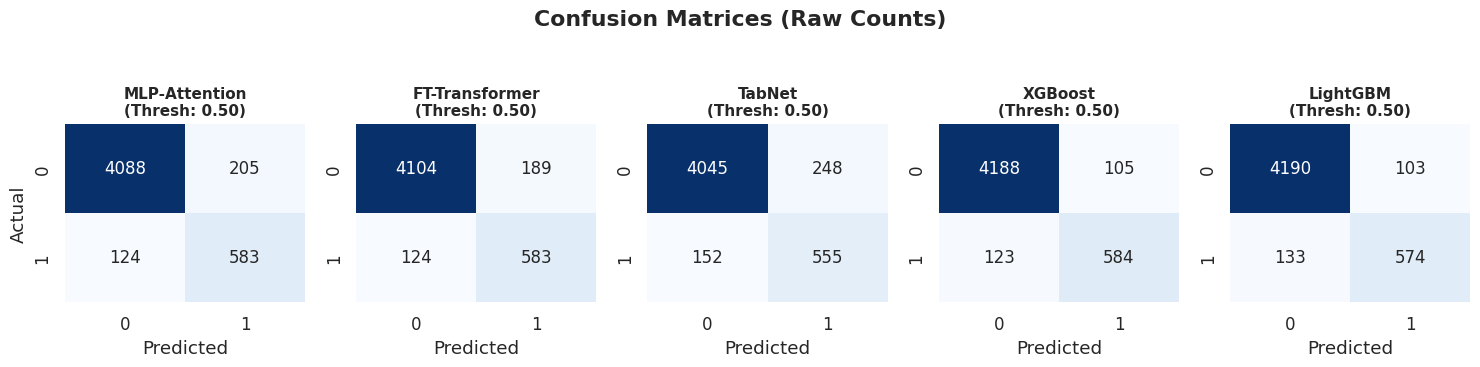

In [ ]:
# --------------------------------------------
# 3. CONFUSION MATRICES (RAW COUNTS)
# --------------------------------------------
n_models = len(roc_data)
fig, axes = plt.subplots(1, n_models, figsize=(3 * n_models, 3.5))

if n_models == 1: axes = [axes]

for ax, (model_name, (y_true, y_prob)) in zip(axes, roc_data.items()):

    # Use the saved threshold if it exists, otherwise default to 0.5
    # (If you haven't re-run training yet, this will default to 0.5)
    thresh = final_thresholds.get(model_name, 0.5) if 'final_thresholds' in locals() else 0.5

    y_pred = (y_prob >= thresh).astype(int)

    # --- CHANGE 1: Remove 'normalize' argument to get raw counts ---
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",      # --- CHANGE 2: 'd' stands for Integer (no decimals/percents) ---
        cmap="Blues",
        cbar=False,
        ax=ax,
        annot_kws={"size": 12}
    )

    ax.set_title(f"{model_name}\n(Thresh: {thresh:.2f})", fontsize=11, fontweight='bold')

    ax.set_xlabel("Predicted")
    if ax == axes[0]: ax.set_ylabel("Actual")
    else: ax.set_ylabel("")

plt.suptitle("Confusion Matrices (Raw Counts)", y=1.05, fontweight="bold")
plt.tight_layout()
plt.show()

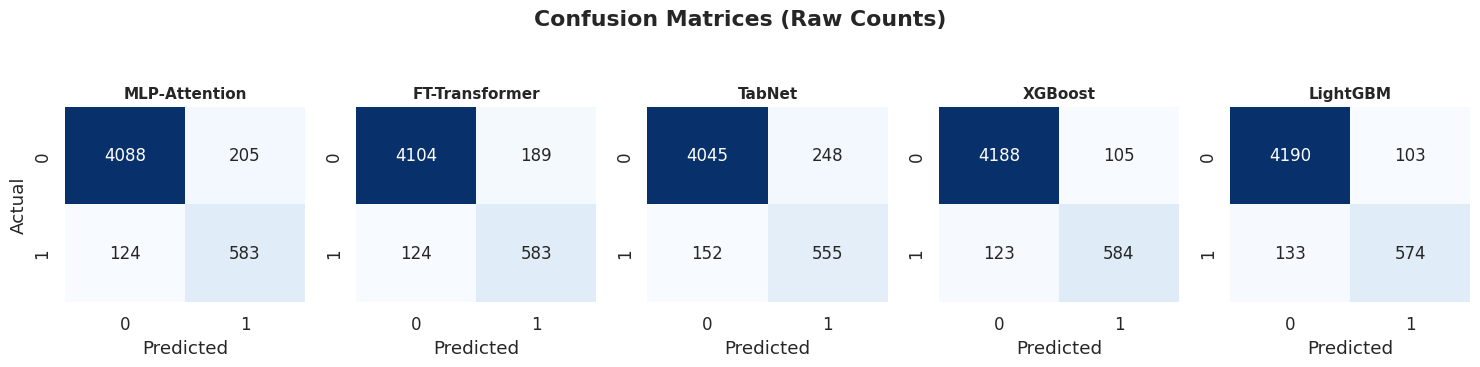

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --------------------------------------------
# 3. CONFUSION MATRICES (RAW COUNTS)
# --------------------------------------------
n_models = len(roc_data)
fig, axes = plt.subplots(1, n_models, figsize=(3 * n_models, 3.5))

if n_models == 1: axes = [axes]

for ax, (model_name, (y_true, y_prob)) in zip(axes, roc_data.items()):

    # Use the saved threshold if it exists, otherwise default to 0.5
    thresh = final_thresholds.get(model_name, 0.5) if 'final_thresholds' in locals() else 0.5

    y_pred = (y_prob >= thresh).astype(int)

    # Calculate raw counts (no normalization)
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",      # 'd' ensures raw integers are displayed
        cmap="Blues",
        cbar=False,
        ax=ax,
        annot_kws={"size": 12}
    )

    # --- UPDATED: Title now contains ONLY the model name ---
    ax.set_title(model_name, fontsize=11, fontweight='bold')

    ax.set_xlabel("Predicted")
    if ax == axes[0]: ax.set_ylabel("Actual")
    else: ax.set_ylabel("")

plt.suptitle("Confusion Matrices (Raw Counts)", y=1.05, fontweight="bold")
plt.tight_layout()
plt.show()